In [1]:
import numpy as np
import scipy as sp
import scipy.special as spe
import scipy.interpolate as interpolate
import csv
# Carlos' special sauce
import neutrinocommon
import neutrinocommon.neu.xsections as xs
import neutrinocommon.physconst.physicsconstants as PC
import neutrinocommon.neu.neuosc as no
import neutrinocommon.astro.body as bd
import neutrinocommon.exp.icecube as ice
import neutrinocommon.tools.generaltools as gt

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
%matplotlib inline
# Allow LaTeX plotting
# Example:
# plt.xlabel(r'\textbf{time} (s)')
# plt.ylabel(r'\textit{voltage} (mV)',fontsize=16)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

NC:NEU:XSECTIONS:ERROR: Loading NUSIGMA interface : nudsde.
NC:NEU:NEUOSC:ERROR: Loading GSL python interface : pygsl.
NC:NEU:NEUOSC:ERROR: Loading NUSIGMA interface : nudsde.


In [65]:
pc              = PC.PhysicsConstants()
DM_cs           = 1.0e-36*pc.cm**2
dataPath        = '/data/user/jlazar/data/solarWIMP/data/sun/'
plotPath        = '/data/user/jlazar/data/solarWIMP/plots/sun/'
validSurfaces   = ['sunCore', 'sunSurface', 'earthSurface']
radii           = {'sunCore':1.e6,'sunSurface':6.957e10,'earthSurface':1.496e13}
ch_wimpsim      = {'dd':1,'uu':2,'ss':3,'cc':4,'bb':5,'tt':5,'gg':7,'WW':8,'ZZ':9,'mumu':10,'tautau':11,'nuenue':12,'numunumu':13,'nutaunutau':14}
nu_wimpsim      = {'nu_e':0, 'nu_mu':1, 'nu_tau':2, 'nu_e_bar':3, 'nu_mu_bar':4, 'nu_tau_bar':5 }
niceSurfs       = {'sunSurface': 'sun surface','sunCore': 'sun core','earthSurface': 'earth surface'}
niceNu          = {'nu_e':'\$\nu_{e}$', 'nu_mu':'\$\nu_{\mu}$', 'nu_tau':'\$\nu_{\tau}$', '\$\bar{nu_{e}}$':'\$\bar{nu_{e}}$', 'nu_mu_bar':'\$\bar{nu_{\mu}}$', 'nu_tau_bar':'\$\bar{nu_{\tau}}$'}

In [3]:
#def funcBetaPlus(dmMass,nucMass):
#    return 4.*dmMass*nucMass/((dmMass+nucMass)**2)

#def funcBetaMinus(dmMass,nucMass):
#    return 4.*dmMass*nucMass/((dmMass-nucMass)**2)

#def regularA(betaMinus,vel,velChar):
#    return np.sqrt(betaMinus*vel**2/velChar**2)

#def etaUp(a,eta):
#    return eta / np.sqrt(1+a)

#def etaDn(b,eta):
#    return eta / np.sqrt(1+b)

#def AUpPlus(A,a,eta):
#    return A*np.sqrt(1+a) + etaUp(a,eta)

#def AUpMinus(A,a,eta):
#    return A*np.sqrt(1+a) - etaUp(a,eta)

#def ADnPlus(A,b,eta):
#    return A*np.sqrt(1+b) + etaDn(b,eta)

#def ADnMinus(A,b,eta):
#    return A*np.sqrt(1+b) - etaDn(b,eta)

In [4]:
# Calculates term outside parenthesis in eq 2.18
#def gouldCoefficient(sigma0,dmRho,massSun,velChar,Q,ep,eta,a):
#    return sigma0*dmRho*massSun*velChar*(Q**2.)*ep/(2.*eta*a)

# Calculates first term in parenthesis in eq 2.18
#def gouldFirstTerm(a,eta):
#    eUp = etaUp(a,eta)
#    return 2.*np.exp(-a*(eUp**2.))*spe.erf(eUp)/np.sqrt(1.+a) # check etaUp ?? 

# Calculates second term in parenthesis in eq 2.18
#def gouldSecondTerm(ACenter,ASurface,eta,a):
#    eUp = etaUp(a,eta)
#    return np.exp(-a*(eUp**2.))/((ACenter**2.-ASurface**2.)*((1.+a)**(1.5)))

# Calculates third term in parenthesis in eq 2.18
#def gouldThirdTerm(A,a,b,eta):
#    APlus  = AUpPlus(A,a,eta)
#    AMinus = AUpMinus(A,a,eta)
#    tmp    = (APlus*AMinus-1./2.-(1.+a)/(a-b))*(spe.erf(APlus)-spe.erf(AMinus))
#    result = tmp + (AMinus*np.exp(-(APlus**2.))-APlus*np.exp(-(AMinus**2.)))/np.sqrt(np.pi)
#    return result

# Calculates fourth term in parenthesis in eq 2.18
def gouldFourthTerm(A,ASurface,ACenter,a,b,eta):
    eDn = etaDn(b,eta)
    APlus  = ADnPlus(A,a,eta)
    AMinus = ADnMinus(A,a,eta)
    tmp = (2.*spe.erf(eDn)-spe.erf(APlus)+spe.erf(AMinus))*np.exp((b-a)*(A**2.))
    result = tmp*np.exp(-b*(eDn**2.))/((a-b)*(ACenter**2.-ASurface**2.)*np.sqrt(1.+b))
    return result

def gouldExpression(sigma0,dmRho,massSun,velChar,Q,ep,ASurface,ACenter,a,b,eta):
    coef = gouldCoefficient(sigma0,dmRho,massSun,velChar,Q,ep,eta,a)
    t1 = gouldFirstTerm(a,eta)
    t2 = gouldSecondTerm(ACenter, ASurface,a,eta)
    t3 = gouldThirdTerm(ACenter,a,b,eta) - gouldThirdTerm(ASurface,a,b,eta)
    t4 = gouldFourthTerm(ACenter,ASurface,ACenter,a,b,eta) \
         -gouldFourthTerm(ASurface,ASurface,ACenter,a,b,eta)
    result = coef*(t1-t2*t3+t4)
    return result

In [5]:
def DMSunCaptureRate(dmMass, dmCs, param,verbose=False):

    """ Calculates DM capture rate in the sun using Gould's formula.

    Ref: Cosmological density of WIMPs from solar and terresterial annihilations. A. Gould.
    The Astrophysical Journal, 388:338-344, 1992 April
    """
    
    elements        = {0:'H',1:'He',2:'C',3:'N',4:'O',5:'Ne',6 :'Mg',7:'Si',8:'S',9:'Fe'}              # elements in sun
    massNum         = [1.0,4.0,12.0,14.0,16.0,20.0,24.0,28.0,32.0,56.0]                                # A : mass number
    massGrPerMol    = [1.0079,4.0026,12.0107,14.0067,15.9994,20.1797,24.3051,28.0855,32.0655,55.8452]  # gr mol^-1
    eps             = [0.772,0.209,3.87e-3,9.4e-4,8.55e-3,1.51e-3,7.39e-4,8.13e-4,4.65e-4,1.46e-3]     # relative abundances in Sun from tbl 8 Jungman p.299
    n = len(elements)
    
    # input data
    mass_eV         = [ m*param.gr/param.Na for m in massGrPerMol ]
    # Make sure this is correct formula for radius
    #atomicRadius   = [ 1.2*param.fermi*np.power(A, 1./3.)/param.Na for A in massNum ]  # Why were we dividing by Na
    nuclearRadius   = [ 1.2*param.fermi*np.power(A, 1./3.) for A in massNum ]
    energyElement   = [ 3. / (2*mass_eV[i]*nuclearRadius[i]**2) for i in range(n) ]     # energy defined in Gould eq 2.5
    dmRho           = 0.3*param.GeV/param.cm**3                                         # dm density Ref : arXiv 1105.6339
    massSun         = 1.9891e30*param.kg
    eta             = 1.0
    
    """ Gould's velocity definitions.
    Are these still good numbers?
    """
    velCenter       = 1354*param.km/param.sec  # Gould eq 2.14
    velSurface      = 795*param.km/param.sec   # Gould eq 2.14
    velRot          = 220.*param.km/param.sec  # Gould page 341 below eq 19
    velChar         = velRot/eta
    
    # Jungman velocity definitions
    velBar          = 220.*param.km/param.sec
    velStar         = np.sqrt(3.0/2.0)*velBar/eta
    
    
    # define Gould's auxilary variables
    bPlus        = [ funcBetaPlus(dmMass,m) for m in mass_eV ]
    bMinus       = [ funcBetaMinus(dmMass,m) for m in mass_eV ]
    #sigma0          = [ dmCs for i in range(n) ]
    sigma0          = dmCs
    a               = [ dmMass*velChar**2/(2.*e) for e in energyElement ]
    b               = [ bPlus[i]*a[i] for i in range(n) ]
    #etaUp           = [ eta/np.sqrt(1+x) for x in a ]
    #etaDn           = [ eta/np.sqrt(1+x) for x in b ]
    #A              = lambda beta, vel : np.sqrt(beta)*vel/velChar
    #AUpHatPlus     = lambda A, a : A*np.sqrt(1+a) + etaUpHat
    #AUpHatMinus    = lambda A, a : A*np.sqrt(1+a) - etaUpHat
    #ADnHatPlus     = lambda A, b : A*np.sqrt(1+b) + etaDnHat
    #ADnHatMinus    = lambda A, b : A*np.sqrt(1+b) - etaDnHat
    ACenter         = [ regularA(x,velCenter,velChar) for x in bMinus ]
    ASurface        = [ regularA(x,velSurface,velChar) for x in bMinus ]
    
    # special assumptions (WHERE DID THIS COME FROM)
    reduce_mass     = lambda m1,m2 : m1*m2/(m1+m2)
    pMass           = 938.272*param.MeV         # proton mass
    q               = [(massNum[i]*reduce_mass(dmMass,mass_eV[i])/reduce_mass(dmMass,pMass))/np.sqrt(bPlus[i]*mass_eV[i]*dmMass) for i in range(n)]
    
    #Do the calculation term by term
    #coefs           = [ gouldCoefficient(sigma0,dmRho,massSun,velChar,q[i],eps[i],eta,a[i]) \
    #                     for i in range(n) ]
    #T1              = [ gouldFirstTerm(a[i],etaUp[i]) \
    #                     for i in range(n) ]
    #T2              = [ gouldSecondTerm(ACenter[i],ASurface[i],a[i],etaUp[i]) \
    #                     for i in range(n)]
    #T3              = [ gouldThirdTerm(ACenter[i],a[i],b[i],etaUp[i]) - \
    #                    gouldThirdTerm(ASurface[i],a[i],b[i],etaUp[i]) \
    #                    for i in range(n) ]
    #T4              = [ gouldFourthTerm(ACenter[i],ASurface[i],ACenter[i],a[i],b[i],etaDn[i]) - \
    #                    gouldFourthTerm(ASurface[i],ASurface[i],ACenter[i],a[i],b[i],etaDn[i]) \
    #                    for i in range(n) ]
    #rates = [ coefs[i]*(T1[i]-T2[i]*(T3[i]+T4[i])) for i in range(n)]
    #print(rates)
    #rate = np.sum(rates)
    rates = [ gouldExpression(sigma0,dmRho,massSun,velChar,q[i],eps[i],ASurface[i],ACenter[i],a[i],b[i],eta) \
              for i in range(n)]
    if verbose:
        print(rates)
    rate = np.sum(rates)
    #return rate
    return rates


In [6]:
#dmMass = 1e11
#dmCs = DM_cs
#param = pc

#elements        = {0:'H',1:'He',2:'C',3:'N',4:'O',5:'Ne',6 :'Mg',7:'Si',8:'S',9:'Fe'}              # elements in sun
#massNum         = [1.0,4.0,12.0,14.0,16.0,20.0,24.0,28.0,32.0,56.0]                                # A : mass number
#massGrPerMol    = [1.0079,4.0026,12.0107,14.0067,15.9994,20.1797,24.3051,28.0855,32.0655,55.8452]  # gr mol^-1
#eps             = [0.772,0.209,3.87e-3,9.4e-4,8.55e-3,1.51e-3,7.39e-4,8.13e-4,4.65e-4,1.46e-3]     # relative abundances in Sun from tbl 8 Jungman p.299
#n               = len(elements)
#mass_eV         = [ m*param.gr/param.Na for m in massGrPerMol ]
#nuclearRadius   = [ 1.2*param.fermi*np.power(A, 1./3.) for A in massNum ]
#energyElement   = [ 3. / (2*mass_eV[i]*nuclearRadius[i]**2) for i in range(n) ]                     # energy defined in Gould eq 2.5

# did not check these, but I trust Carlos on this one
#dmRho           = 0.3*param.GeV/param.cm**3
#massSun         = 1.9891e30*param.kg
#eta             = 1.0
#velCenter       = 1354*param.km/param.sec  # Gould eq 2.14
#velSurface      = 795*param.km/param.sec   # Gould eq 2.14
#velRot          = 220.*param.km/param.sec  # Gould page 341 below eq 19
#velChar         = velRot/eta
#velBar          = 220.*param.km/param.sec
#velStar         = np.sqrt(3.0/2.0)*velBar/eta
#q = [ m for m in mass_eV ]

#betaPlus        = [ 4.*dmMass*m/((dmMass+m)**2) for m in mass_eV ]
#betaMinus       = [ 4.*dmMass*m/((dmMass-m)**2) for m in mass_eV ]
#sigma0          = dmCs
#a               = [ dmMass*velChar**2/(2.*e) for e in energyElement ]
#b               = [ betaPlus[i]*a[i] for i in range(n) ]
#etaUp           = [ eta/np.sqrt(1+x) for x in a ]
#etaDn           = [ eta/np.sqrt(1+x) for x in b ]
#ACenter         = [ regularA(x,velCenter,velChar) for x in betaMinus ]
#ASurface        = [ regularA(x,velSurface,velChar) for x in betaMinus ]
#coefs           = [ gouldCoefficient(sigma0,dmRho,massSun,velChar,q[i],eps[i],eta,a[i]) \
#                    for i in range(n) ]
#T1              = [ gouldFirstTerm(a[i],eta) for i in range(n) ]#
#T2              = [ gouldSecondTerm(ACenter[i],ASurface[i],a[i],eta) \
#                    for i in range(n)]
#T3              = [ gouldThirdTerm(ACenter[i],a[i],b[i],eta) - \
#                    gouldThirdTerm(ASurface[i],a[i],b[i],eta) \
#                    for i in range(n) ]
#T4              = [ gouldFourthTerm(ACenter[i],ASurface[i],ACenter[i],a[i],b[i],eta) - \
#                    gouldFourthTerm(ASurface[i],ASurface[i],ACenter[i],a[i],b[i],eta) \
#                    for i in range(n) ]

In [7]:
#dmMass = 1e11
#dmCs = DM_cs
#param = pc

#dmMasses = np.arange(10,991)*pc.GeV
#r = DMSunCaptureRate(15*pc.GeV,dmCs,param,verbose=True)
#r = [DMSunCaptureRate(mass, dmCs, param) for mass in dmMasses]
#_ = [ a[0] for a in r]
#print(len(_))
#nucRate = np.sum(r[1:])

In [8]:
#plt.semilogy(dmMasses/(pc.GeV), _)
#plt.grid()
#plt.show()

In [9]:
# Stealing Carlos' code here

def DMSunAnnihilationRate(DM_mass,DM_cs,eps,param):

    """ Calculates DM capture rate in the sun using Gould's formula.

    Ref: Cosmological density of WIMPs from solar and terresterial annihilations. A. Gould.
    The Astrophysical Journal, 388:338-344, 1992 April
    """
    
    
    elements        = {0:'H',1:'He',2:'C',3:'N',4:'O',5:'Ne',6 :'Mg',7:'Si',8:'S',9:'Fe'}
    mass_num        = [1.0,4.0,12.0,14.0,16.0,20.0,24.0,28.0,32.0,56.0]                                # A : mass number
    mass_gr_per_mol = [1.0079,4.0026,12.0107,14.0067,15.9994,20.1797,24.3051,28.0855,32.0655,55.8452]  # gr mol^-1
    #eps             = [0.745,0.238,0.0039,0.0009,0.0085,0.0015,0.0007,0.0008,0.0005,0.0016]           # relative aboundances
    #eps             = [0.772,0.209,3.87e-3,9.4e-4,8.55e-3,1.51e-3,7.39e-4,8.13e-4,4.65e-4,1.46e-3]    # relative aboundances in the Sun from Table 8 Jungman p.299

    n               = len(elements)

    # input data
    mass_eV         = [m*param.gr/param.Na for m in mass_gr_per_mol]
    atom_radius     = [(1.2*np.power(A,1.0/3.0)*param.fermi) for A in mass_num]

    energy_element  = [3.0/(2.0*mass_eV[i]*atom_radius[i]**2) for i in range(n)]

    DM_rho          = 0.3*param.GeV/param.cm**3 #[Ref : arXiv 1105.6339]
    sun_mass        = 1.9891*1.0e30*param.kg

    eta             = 1.0
    # Gould's velocities definitions
    vel_rot         = 220.0*param.km/param.sec          # local DM rel speed.
    vel_char        = vel_rot/eta
    # Jungman velocities definitions
    vel_bar         = 220.0*param.km/param.sec
    vel_star        = np.sqrt(3.0/2.0)*vel_bar/eta

    vel_surface     = 795.0*param.km/param.sec
    vel_center      = 1354.0*param.km/param.sec

    # special assumptions
    q_i             = [m for m in mass_eV]

    # Gould's auxiliaries variables
    beta_plus       = [(4.0*DM_mass*m_i)/(DM_mass+m_i)**2 for m_i in mass_eV]
    beta_minus      = [(4.0*DM_mass*m_i)/(DM_mass-m_i)**2 for m_i in mass_eV]
    #a               = [DM_mass*vel_char**2/(2.0*E) for E in energy_element]
    a               = [DM_mass*vel_bar**2/(2.0*E) for E in energy_element]
    b               = [a[i]*beta_plus[i] for i in range(n)]

    #A_center        = [np.sqrt(b_min*(vel_center/vel_char)**2) for b_min in beta_minus]
    #A_surface       = [np.sqrt(b_min*(vel_surface/vel_char)**2) for b_min in beta_minus]

    A_center        = [np.sqrt(b_min*(vel_center/vel_bar)**2) for b_min in beta_minus]
    A_surface       = [np.sqrt(b_min*(vel_surface/vel_bar)**2) for b_min in beta_minus]

    eta_up_hat      = [eta/np.sqrt(1.0+aa) for aa in a]
    eta_dn_hat      = [eta/np.sqrt(1.0+bb) for bb in b]

    # Calculate the annihilation rate as
    # Gamma_i = T_0 * (T_1 + T_2 + T_3)
    # relating Gould's sigma_0 to DM_cs
    reduce_mass     = lambda m1,m2 : m1*m2/(m1+m2)
    #sigma_i         = [DM_cs*(mass_num[i]*reduce_mass(DM_mass,mass_eV[i])/reduce_mass(DM_mass,p_mass))**2 for i in range(n)]

    #sigma_0         = [DM_cs/(beta_plus[0]*mass_eV[0]*DM_mass*q_i[0]**2) for i in range(n)]
    #sigma_0         = [sigma_[i]/(beta_plus[i]*mass_eV[i]*DM_mass*q_i[i]**2) for i in range(n)]

    p_mass          = 938.272*param.MeV         # proton mass
    q_i             = [(mass_num[i]*reduce_mass(DM_mass,mass_eV[i])/reduce_mass(DM_mass,p_mass))/np.sqrt(beta_plus[i]*mass_eV[i]*DM_mass) \
                       for i in range(n)]
    sigma_0         = [DM_cs for i in range(n)]

    #T_0             = [(sigma_0[i]*DM_rho*sun_mass*vel_char/(2.0*eta))*(q_i[i]**2*eps[i]/a[i]) for i in range(n)]
    T_0             = [(sigma_0[i]*DM_rho*sun_mass*vel_star/(2.0*eta))*(q_i[i]**2*eps[i]/a[i]) for i in range(n)]

    T_1             = [(2.0*np.exp(-a[i]*eta_up_hat[i]**2)*spe.erf(eta_up_hat[i])/np.sqrt(1.0+a[i])) for i in range(n)]
    T_2             = [- np.exp(-a[i]*eta_up_hat[i]**2)/((A_center[i]**2-A_surface[i]**2)*np.power(1.0+a[i],3.0/2.0))*(GouldAuxF1(A_center[i],a[i],b[i],eta)-GouldAuxF1(A_surface[i],a[i],b[i],eta)) for i in      range(n)]
    T_3             = [np.exp(-b[i]*eta_dn_hat[i]**2)/((a[i]-b[i])*(A_center[i]**2-A_surface[i]**2)*np.sqrt(1.0+b[i]))*(GouldAuxF2(A_center[i],a[i],b[i],eta)-GouldAuxF2(A_surface[i],a[i],b[i],eta)) for i in     range(n)]

    ann_rate_sun    = [T_0[i] * (T_1[i] + T_2[i] + T_3[i]) for i in range(n)]

    #return DMSunAnnihilationJungmanSD(DM_mass,DM_cs,param)
    return np.array(ann_rate_sun)/2.0

In [10]:
def GouldAuxF1(A,a,b,eta):
    """ Calculates part of the DM annihilation as estimated by Gould. This is
    the first termn in {}-brackets on eq. 2.18.

    Ref : Cosmological density of WIMPs from solar and terrestrial annihilations. A. Gould.
    Astrophysical Journal, 388:338-344, 1992 April.

    @type  A      :      float
    @param A      :      Gould's parameter A.
    @type  a      :      float
    @param a      :      Gould's parameter a.
    @type  b      :      float
    @param b      :      Gould's parameter b.
    @type  eta    :      float
    @param eta    :      Gould's parameter eta.

    @rtype        :      float
    @return       :      part of Gould's annihilation formulae.
    """
    A_hat   = A*np.sqrt(1.0+a)
    eta_hat = eta/np.sqrt(1.0+a)

    A_hat_plus = A_hat + eta_hat
    A_hat_minus= A_hat - eta_hat

    return (A_hat_plus*A_hat_minus-0.5-(1+a)/(a-b))*(spe.erf(A_hat_plus)-spe.erf(A_hat_minus))+(1.0/np.sqrt(np.pi))*(A_hat_minus*np.exp(-A_hat_plus**2)-A_hat_plus*np.exp(-A_hat_minus**2))

def GouldAuxF2(A,a,b,eta):
    """ Calculates part of the DM annihilation as estimated by Gould. This is
    the first termn in {}-brackets on eq. 2.18.

    Ref : Cosmological density of WIMPs from solar and terrestrial annihilations. A. Gould.
    Astrophysical Journal, 388:338-344, 1992 April.

    @type  A      :      float
    @param A      :      Gould's parameter A.
    @type  a      :      float
    @param a      :      Gould's parameter a.
    @type  b      :      float
    @param b      :      Gould's parameter b.
    @type  eta    :      float
    @param eta    :      Gould's parameter eta.

    @rtype        :      float
    @return       :      part of Gould's annihilation formulae.
    """
    A_hat   = A*np.sqrt(1.0+b)
    eta_hat = eta/np.sqrt(1.0+b)

    A_hat_plus = A_hat + eta_hat
    A_hat_minus= A_hat - eta_hat

    return (2.0*spe.erf(eta_hat)-spe.erf(A_hat_plus)+spe.erf(A_hat_minus))*np.exp(-(a-b)*A**2)

In [11]:
path = '/data/user/jlazar/data/analysis/'
AGSS09SunCompositionFile = 'struct_b16_agss09.dat'
GS98SunCompositionFile = 'struct_b16_gs98.dat'
elemCols = (6,7,8,9,10,11,12,13,14,15,16,18,20,22,32)

H,He4,He3,C12,C13,N14,N15,O16,O17,O18,Ne,Mg,Si,S,Fe = np.loadtxt(path+GS98SunCompositionFile,comments='#',usecols=elemCols)[-1]
GS98Eps = [H,He4+He3,C12+C13,N14+N15,O16+O17+O18,Ne,Mg,Si,S,Fe]

H,He4,He3,C12,C13,N14,N15,O16,O17,O18,Ne,Mg,Si,S,Fe = np.loadtxt(path+AGSS09SunCompositionFile,comments='#',usecols=elemCols)[-1]
AGSS09Eps = [H,He4+He3,C12+C13,N14+N15,O16+O17+O18,Ne,Mg,Si,S,Fe]

In [12]:
# Capture rates from https://arxiv.org/pdf/0907.3159.pdf
def getArxivData(f):
    arxivCSVPath = '/data/user/jlazar/data/analysis/'
    reader       = csv.reader(open(arxivCSVPath+f, "rb"), delimiter=",")
    x            = list(reader)
    dmMasses     = np.asarray([float(a[0]) for a in x])
    rates        = np.asarray([float(a[1])/10 for a in x])
    return dmMasses, rates
    
arxivNucDMMasses, arxivnucRates = getArxivData('nucCaptureRate.csv')
arxivHDMMasses, arxivHRates     = getArxivData('hCaptureRate.csv')
dmMasses                        = np.arange(10,10000)*pc.GeV
tmp                             = [DMSunAnnihilationRate(m,DM_cs,GS98Eps,pc) for m in dmMasses]
GS98HRate                       = [a[0]*pc.sec for a in tmp]
GS98NucRate                     = [np.sum(a[1:])*pc.sec for a in tmp]
tmp                             = [DMSunAnnihilationRate(m,DM_cs,AGSS09Eps,pc) for m in dmMasses]
AGSS09HRate                     = [a[0]*pc.sec for a in tmp]
AGSS09NucRate                   = [np.sum(a[1:])*pc.sec for a in tmp]
dmMasses = dmMasses/10**9

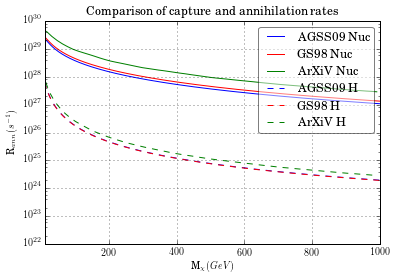

In [13]:
plt.plot(dmMasses,AGSS09NucRate,'b', label='AGSS09 Nuc')
plt.plot(dmMasses,GS98NucRate,'r', label='GS98 Nuc')
plt.plot(arxivNucDMMasses, arxivnucRates,'g',label='ArXiV Nuc')
plt.plot(dmMasses,AGSS09HRate,'b--', label='AGSS09 H')
plt.plot(dmMasses,GS98HRate,'r--',label='GS98 H')
plt.plot(arxivHDMMasses, arxivHRates, 'g--', label='ArXiV H')
plt.title('Comparison of capture and annihilation rates')
plt.ylabel(r'R_{ann} (s^{-1})')
plt.xlabel(r'M_{\chi} (GeV)')
plt.xlim((10,1000))
plt.semilogy()
#plt.semilogx()
plt.grid()
plt.legend(loc=1, fancybox=True, framealpha=0.5)
plt.savefig('dm_capture_rates.png')
plt.show()
plt.close()

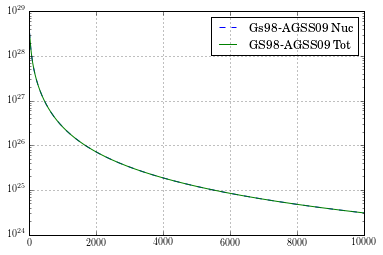

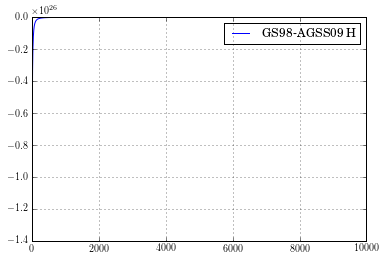

In [14]:
hDif     = [GS98HRate[i] - AGSS09HRate[i] for i in range(len(AGSS09HRate))] 
nucDif   = [GS98NucRate[i] - AGSS09NucRate[i] for i in range(len(AGSS09NucRate))]
totaldif = [nucDif[i] + hDif[i] for i in range(len(nucDif))]

plt.plot(dmMasses,nucDif,'--',label='Gs98-AGSS09 Nuc')
plt.plot(dmMasses,totaldif,label='GS98-AGSS09 Tot')
plt.grid()
plt.legend()
plt.semilogy()
plt.show()
plt.close()

plt.plot(dmMasses,hDif,label='GS98-AGSS09 H')
plt.grid()
plt.legend()
#plt.semilogy()
plt.show()
plt.close()


In [15]:
# event estimation

def DMneuDet(flavor,Enu,ch,DMm,DMsig,body,param,osc,eps):
    """ Calculates Spectra contained event number at detection at a 1 Mton-year Icecube-like detector.

    Using the adiabatic aproximation to estimate the probability of survival
    Assuming standard DM parameters for the annhiliation rate we calculate the
    DM-neu spectra at Earth. Then we multiply by the neu-nucleon cross section
    and estimate the number of nuclei in a Mton ice detector. Finally we
    multiply by the exposure and DM sun-annihilation rate.

    Calculation :

    dN/dE_nu = T * Gamma_ann_rate * Phi_nu(E)_per_ann * cross-section(E) * N_nucleons * P_survival

    @type   flavor  :   integer
    @param  flavor  :   neutrino flavor (0:e,1:mu,2:tau)
    @type   Enu     :   float
    @param  Enu     :   neutrino energy [eV]
    @type   ch      :   string
    @param  ch      :   dark matter annhilation channel
    @type   DMm     :   float
    @param  DMm     :   dark matter mass [eV]
    @type   body    :   body
    @param  body    :   body with the asociated density profile.
    @type   param   :   physicsconstants
    @param  param   :   set of physical parameters to be used.
    @type   osc     :   boolean
    @param  osc     :   if true will consider neu-osc.

    @rtype          :   float
    @return         :   dN/dE|detector at E = Enu
    """
    ##B From Arxiv: 0506298 ec. 21 & 24
    #DM_annihilation_rate_Earth  = 1.0e14*(100*param.GeV/DMm)**2/param.sec   #[annhilations/s]
    #DM_annihilation_rate_Sun    = ((1.0*param.AU)/(param.EARTHRADIUS*param.km))**2*DM_annihilation_rate_Earth

    DM_annihilation_rate_Sun = float(np.sum(DMSunAnnihilationRate(DMm,DMsig,eps,param))) # [eV^-1]

    ##E
    det_exposure    = 1.0*param.year
    det_mass        = 1.0e9*param.kg
    A               = 18.0*param.gr #[gr/mol]
    n_for_n         = 18.0 # [nucleons per nuclei]
    det_nucleons    = n_for_n*(det_mass/A)*param.Na

    evt = 0.0
    if param.neutype == "neutrino":
        if osc :
            for flv in range(3):
                #p = DMParameters(flv)
                if body.name != "vacuum":
                    #evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                    #      DMSweFlux(Enu/param.GeV,flv*2,ch,DMm/param.GeV)*xs.signuNCC(Enu/param.GeV,0)*param.cm**2*\
                    #      no.AvgNeuProb_RK_STD(flv,flavor,Enu,param)
                    evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                          DMSweFlux(Enu/param.GeV,flv*2,ch,DMm/param.GeV)*xs.nuDISxsection_CC_NusigmaInt(Enu/param.GeV,flavor,pc)*\
                          param.cm**2*no.AvgNeuProb_RK_STD(flv,flavor,Enu,param)
                else :
                    PMNS = no.mixmatrix(param)
                    #evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                    #      DMSweFlux(Enu/param.GeV,flv*2,ch,DMm/param.GeV)*xs.signuNCC(Enu/param.GeV,0)*\
                    #      param.cm**2*no.AvgProbNeuVacuum(flv,flavor,PMNS,param)
                    evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                          DMSweFlux(Enu/param.GeV,flv*2,ch,DMm/param.GeV)*xs.nuDISxsection_CC_NusigmaInt(Enu/param.GeV,flavor,pc)*\
                          param.cm**2*no.AvgProbNeuVacuum(flv,flavor,PMNS,param)
        else :
            #p = DMParameters(flavor)
            evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                  DMSweFlux(Enu/param.GeV,flavor*2,ch,DMm/param.GeV)*xs.nuDISxsection_CC_NusigmaInt(Enu/param.GeV,flavor,pc)*param.cm**2
            #evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
            #      DMSweFlux(Enu/param.GeV,flavor*2,ch,DMm/param.GeV)*xs.signuNCC(Enu/param.GeV,0)*param.cm**2
            #evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
            #      DMFlux(Enu,DMm,ch,p)*xs.signuNCC(Enu/param.GeV,0)*param.cm**2#/ycorr
        return evt
    elif param.neutype == "antineutrino":
        if osc :
            for flv in range(3):
                #p = DMParameters(flv)
                if body.name != "vaccum":
                    evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                          DMSweFlux(Enu/param.GeV,flv*2+1,ch,DMm/param.GeV)*xs.nuDISxsection_CC_NusigmaInt(Enu/param.GeV,flavor,pc)*\
                          param.cm**2*no.AvgNeuProb_RK_STD(flv,flavor,Enu,param)
                    #evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                    #      DMSweFlux(Enu/param.GeV,flv*2+1,ch,DMm/param.GeV)*xs.signuNCC(Enu/param.GeV,1)*param.cm**2*\
                    #      no.AvgNeuProb_RK_STD(flv,flavor,Enu,param)
                    #evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                    #      DMFlux(Enu,DMm,ch,p)* xs.signuNCC(Enu/param.GeV,1)*param.cm**2*\
                    #      no.AvgNeuProb_RK_STD(flv,flavor,Enu,param)
                else :
                    PMNS = no.mixmatrix(param)
                    evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                          DMSweFlux(Enu/param.GeV,flv*2+1,ch,DMm/param.GeV)*xs.nuDISxsection_CC_NusigmaInt(Enu/param.GeV,flavor,pc)*\
                          param.cm**2*no.AvgProbNeuVacuum(flv,flavor,PMNS,param)
                    #evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                    #      DMSweFlux(Enu/param.GeV,flv*2+1,ch,DMm/param.GeV)*xs.signuNCC(Enu/param.GeV,1)*\
                    #      param.cm**2*no.AvgProbNeuVacuum(flv,flavor,PMNS,param)
                    #evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                    #      DMFlux(Enu,DMm,ch,p)* xs.signuNCC(Enu/param.GeV,1)*param.cm**2*\
                    #      no.AvgNeuProb_RK(flv,flavor,Enu,param)#/ycorr
        else :
            #p = DMParameters(flavor)
            evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
                  DMSweFlux(Enu/param.GeV,flavor*2+1,ch,DMm/param.GeV)*xs.nuDISxsection_CC_NusigmaInt(Enu/param.GeV,flavor,pc)*\
                  param.cm**2#/ycorr
            #evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
            #      DMSweFlux(Enu/param.GeV,flavor*2+1,ch,DMm/param.GeV)*xs.signuNCC(Enu/param.GeV,1)*param.cm**2#/ycorr
            #evt = evt + det_nucleons*det_exposure*(DM_annihilation_rate_Sun/(4.0*np.pi*param.AU**2))*\
            #      DMFlux(Enu,DMm,ch,p)*xs.signuNCC(Enu/param.GeV,0)*param.cm**-2/ycorr
        return evt
    else :
        print "Wrong neutrino type."
        quit()

In [16]:
def DMSweFlux(Enu,neuflavor,ch,DMm,AtEarth=True):
    """ Gets dN/dz(z) using de swedish data set.
    @type  Enu          :      float
    @param Enu          :      neutrino energy [GeV]
    @type  neuflavor    :      integer
    @param neuflavor    :      flavor of the neutrino (0 : nu_e, 1 : anu_e, 2 : nu_mu 0, 3 : anu_mu, 4 : nu_tau, 5 : anu_tau)
    @type  ch           :      string
    @param ch           :      annihilation channel
    @type  DMm          :      float
    @param DMm          :      dark matter mass [GeV]

    @rtype              :      array
    @return             :      z = E/DMm, dN/dz(z) arrays at production (??)
    """
    if PC.act_channel == ch and PC.act_DM_mass == DMm and PC.act_neuflavor == neuflavor and PC.flag_inter:
        if Enu/DMm < 0.0025:
            return 0.0
        elif Enu/DMm <= 0.9975:
            return PC.act_inter(Enu/DMm)
        elif Enu/DMm > 0.9975:
            return 0.0
        else :
            print "Interpolation error."
            quit()
    else:
        #print "reloading DM initial flux"
        DMmstring = format(DMm,'.0f')
        filename = "wa-m"+str(DMmstring)+"-ch"+str(ch_wimpsim[ch])+"-sun-sum.dat"
        file = open(datDMFluxSweden + filename,'r')
        #z = np.arange(0.0025,0.9975,0.005)
        z=np.linspace(0.0,1.,200)
        h,dat = gt.hreadfilev2(file)
        xneuflavor=neuflavor
        if AtEarth:
            xneuflavor+=12
        dn_dz = dat[xneuflavor]
        print dat

        PC.act_channel, PC.act_DM_mass, PC.act_neuflavor,PC.flag_inter = ch,DMm,neuflavor,False

        if Enu/DMm < z[0]:
            return 0.0
        elif Enu/DMm <= z[-1]:
            inter = sp.interpolate.interp1d(z,dn_dz)
            #inter = sp.interpolate.UnivariateSpline(z,dn_dz)
            PC.act_inter = inter
            PC.flag_inter = True
            return inter(Enu/DMm)
        elif Enu/DMm > z[-1]:
            return 0.0
        else :
            print "Interpolation Error."
            quit()

In [17]:
filepath = neutrinocommon.astro.__path__
datDMFlux = filepath[0] + "/data/dm/DMnuProdParameters/"
datDMFluxSweden = filepath[0] + "/data/dm/wimpsim/"

#GS98bb = [DMneuDet(0,m/2,'dd',m,DM_cs,bd.Sun,pc,False,GS98Eps) for m in [100,1000,10000]]

In [39]:
def makeWIMPSimString(dmMass,ch):
    return 'wa-m'+str(dmMass)+'-ch'+str(ch_wimpsim[ch])+'-sun-sum.dat'

def getdNdZ(mass, ch, surface):
    assert surface in validSurfaces
    f    = dataPath + makeWIMPSimString(mass,ch)
    data = np.loadtxt(f,comments='#')
    if surface=='sunSurface':
        data = data[6:]
    elif surface=='earthSurface':
        data = data[12:]
    return data[:6]

def makePlotFromWimpSim(dmMass,channels,surface,save=False):
    assert surface in validSurfaces
    r2 = radii[surface]**2
    for c in channels:
        data       = getdNdZ(dmMass, c, surface)
        nudNdZ     = data[0] + data[1] + data[2]
        nuBardnNdZ = data[3] + data[4] + data[5]
        z          = np.linspace(0,1,len(nudNdZ))
        p = plt.plot(z,nudNdZ/(4*np.pi*r2*dmMass),label=c)
        plt.plot(z,nuBardnNdZ/(4*np.pi*r2*dmMass),p[0].get_color()+'--')
    plt.ylabel(r'$\frac{dN}{dz}$ $\left(ann^{-1}GeV^{-1}cm^{-2}\right)$')
    plt.xlabel(r'z=$\frac{E_{\nu}}{m_{\chi}}$')
    plt.semilogy()
    plt.legend(loc='best', fancybox=True, framealpha=0.5)
    plt.title('Differential flux at '+ surface+' m='+str(dmMass)+' GeV')
    if save:
        plt.savefig(plotOutPath+'wa-m'+str(dmMass)+'-'+surface+'-sun-sum.png')
    plt.show()

10sunSurface could not be made


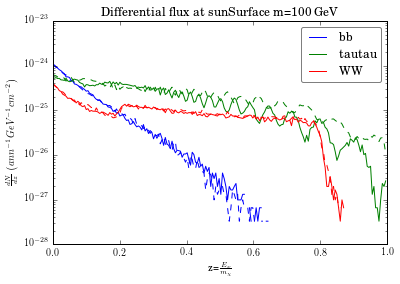

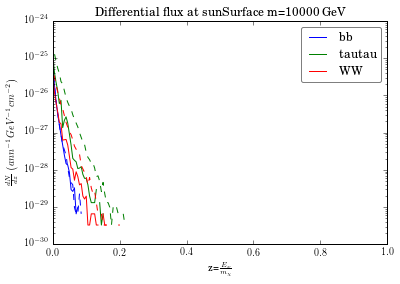

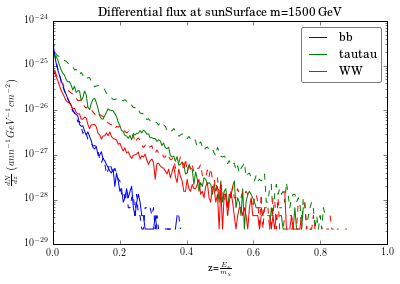

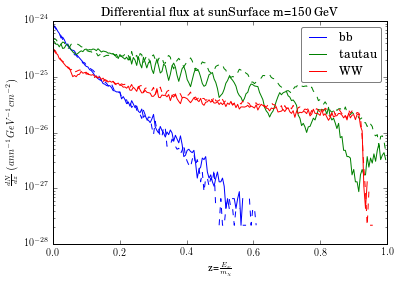

15sunSurface could not be made


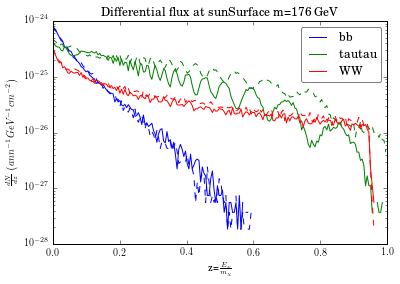

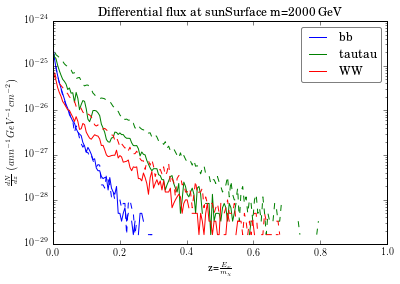

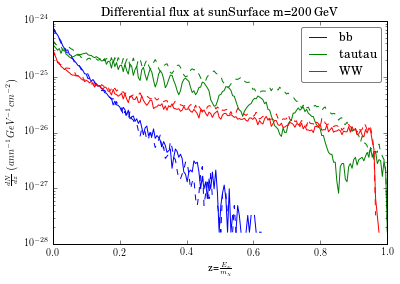

20sunSurface could not be made


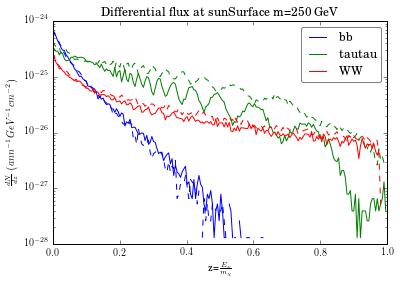

25sunSurface could not be made


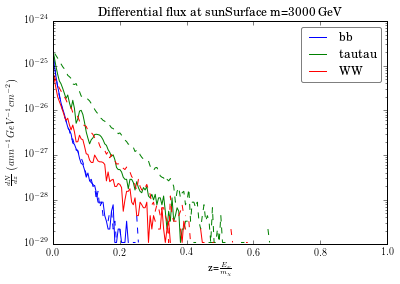

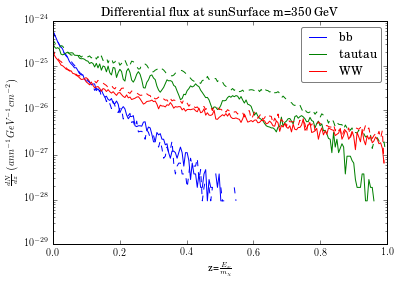

35sunSurface could not be made
3sunSurface could not be made
4sunSurface could not be made


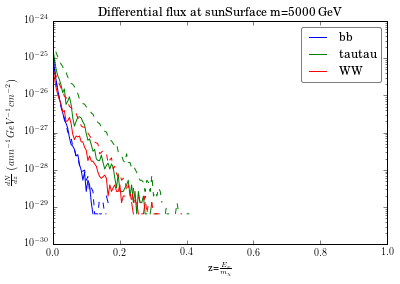

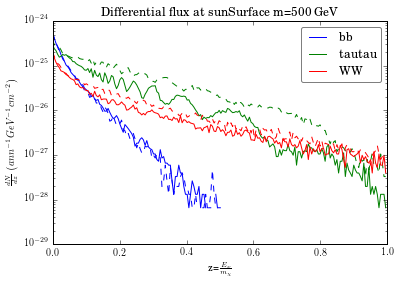

50sunSurface could not be made
5sunSurface could not be made
6sunSurface could not be made


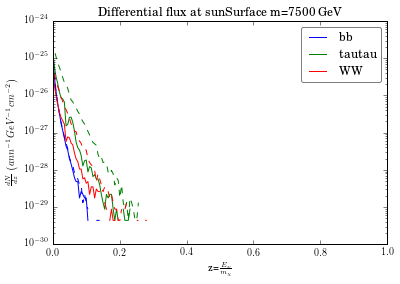

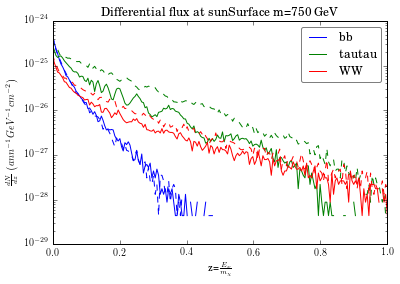

80sunSurface could not be made
8sunSurface could not be made
91sunSurface could not be made
10sunCore could not be made


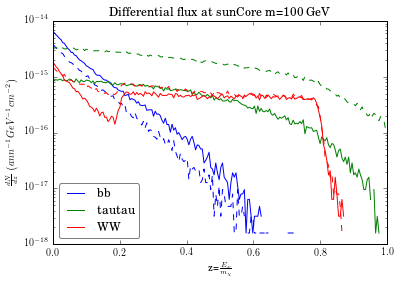

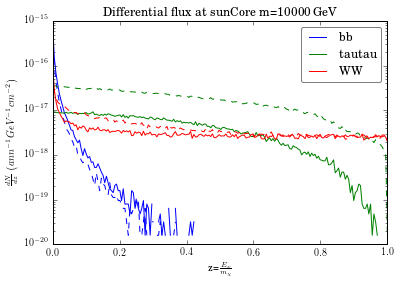

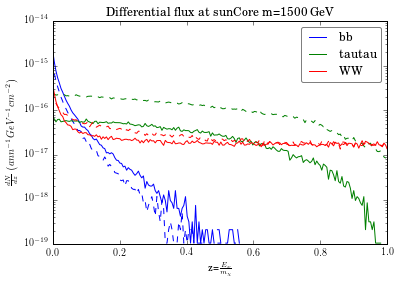

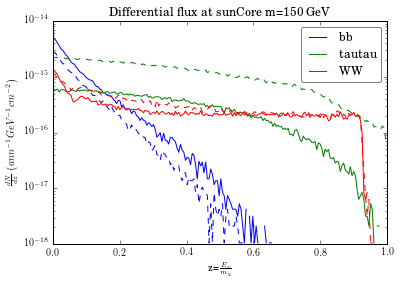

15sunCore could not be made


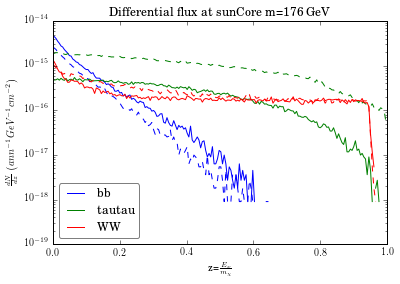

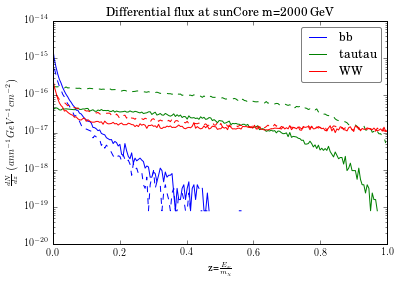

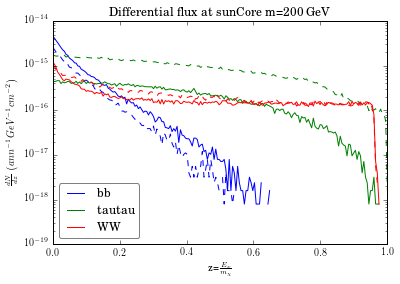

20sunCore could not be made


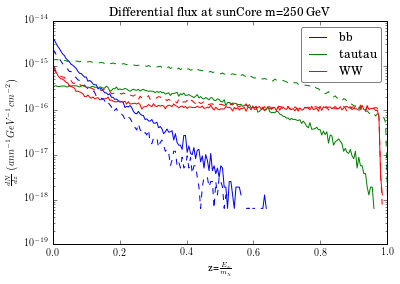

25sunCore could not be made


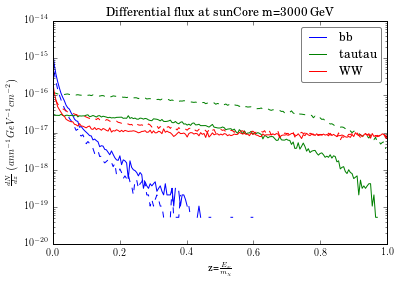

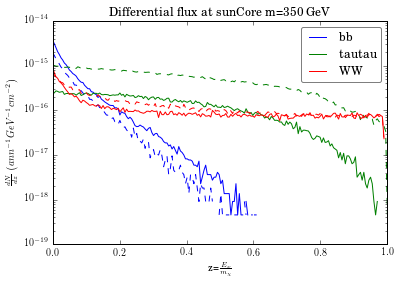

35sunCore could not be made
3sunCore could not be made
4sunCore could not be made


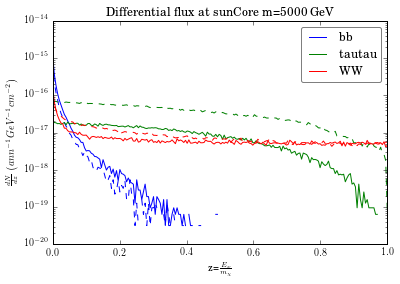

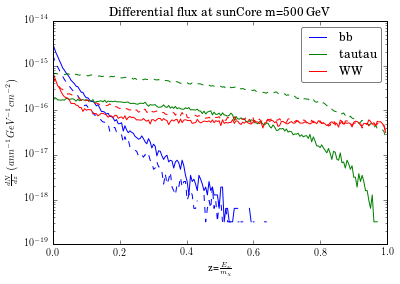

50sunCore could not be made
5sunCore could not be made
6sunCore could not be made


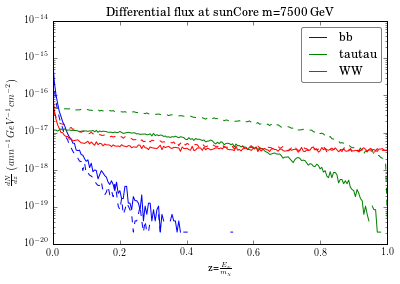

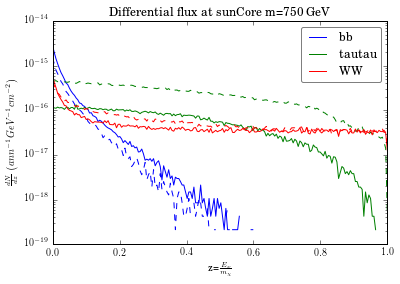

80sunCore could not be made
8sunCore could not be made
91sunCore could not be made
10earthSurface could not be made


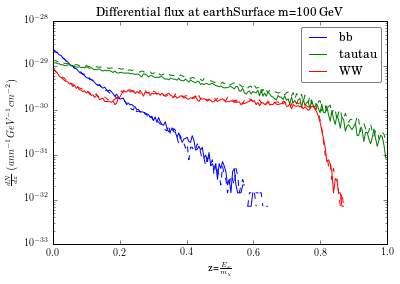

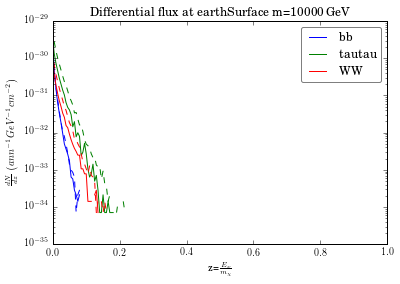

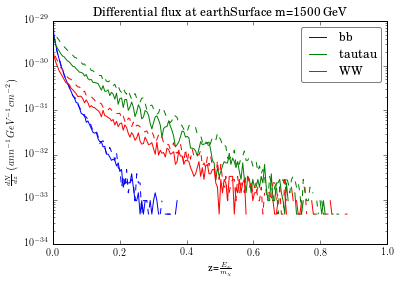

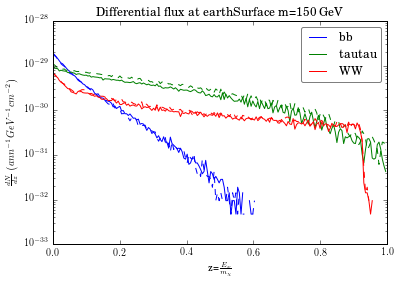

15earthSurface could not be made


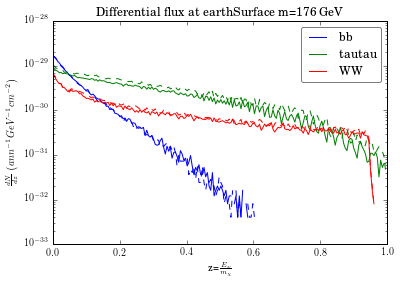

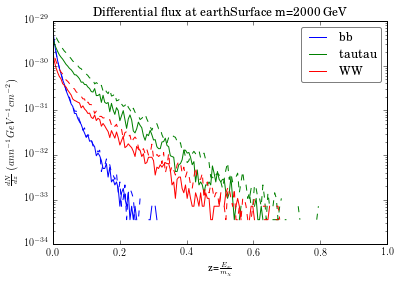

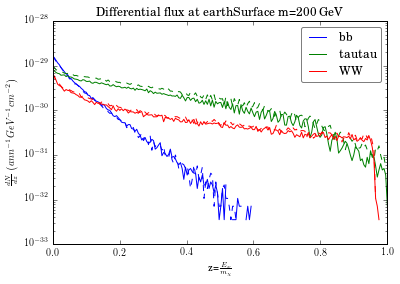

20earthSurface could not be made


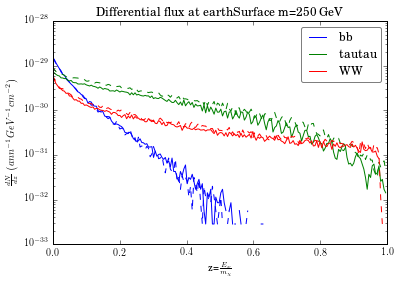

25earthSurface could not be made


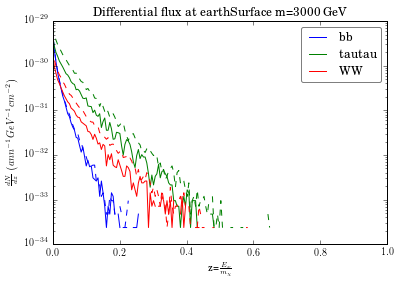

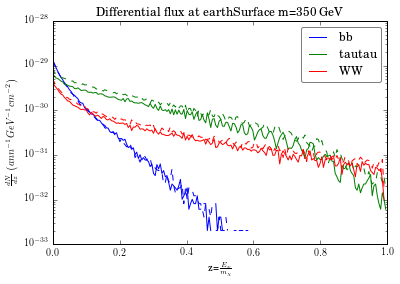

35earthSurface could not be made
3earthSurface could not be made
4earthSurface could not be made


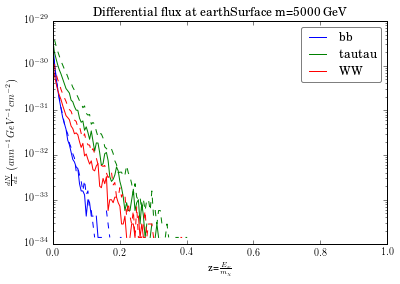

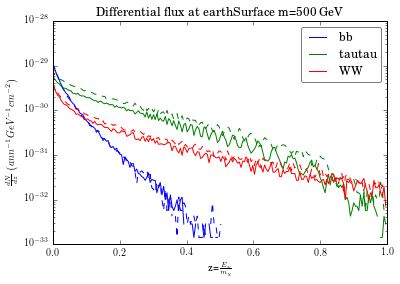

50earthSurface could not be made
5earthSurface could not be made
6earthSurface could not be made


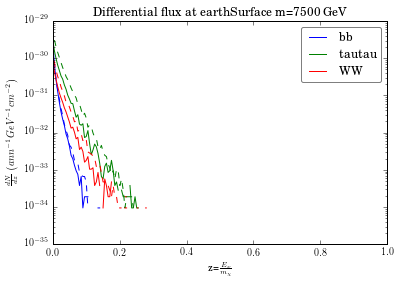

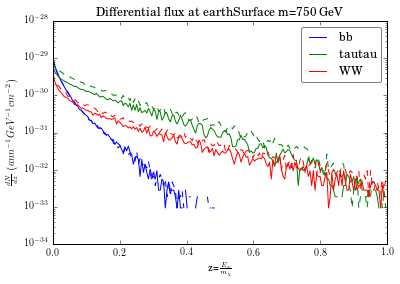

80earthSurface could not be made
8earthSurface could not be made
91earthSurface could not be made


In [25]:
surfs = ['sunSurface','sunCore','earthSurface']
ms    = [10,100,10000,1500,150,15,176,2000,200,20,250,25,3000,350,35,3,4,5000,500,50,5,6,7500,750,80,8,91]
chans = ['bb','tautau','WW']

for s in surfs:
    for m in ms:
        try:
            makePlotFromWimpSim(m,chans,s,save=True)
        except IOError:
            plt.close()
            print(str(m)+s+' could not be made')

In [30]:
def NeuOsc3gVacuum(a,b,E,L,param):
    """ Formalae for standard 3-flavor neutrino oscillation
    # FUNDAMENTALS OF NEUTRINO PHYSICS GIUNTI pag. 252
    #       E       : neutrino energy       [eV]
    #       L       : distance              [eV^-1]
    #       a       : initial neutrino flavor (0 : e, 1 : mu, 2 : tau)
    #       b       : final neutrino flavor (0 : e, 1 : mu, 2 : tau)
    """
    param.Refresh()
    PMNS = no.MixMatrix(param)
    U = PMNS.U
    UCT = PMNS.UCT
    rt,it =[],[]
    [[ rt.append(np.real(UCT[k,a]*U[b,k]*U[a,j]*UCT[j,b])*np.sin(param.dm2[j+1,k+1]*L/(4.0*E))**2)  for k in range(param.numneu) if k>j] for j in range(param.numneu)]
    [[ it.append(np.imag(UCT[k,a]*U[b,k]*U[a,j]*UCT[j,b])*np.sin(param.dm2[j+1,k+1]*L/(2.0*E)))     for k in range(param.numneu) if k>j] for j in range(param.numneu)]

In [48]:
def getCompData(dmMass,channel,nuType):
    assert nuType in nu_wimpsim
    data = []
    try:
        for s in validSurfaces:
            data.append((getdNdZ(dmMass, channel, s)[nu_wimpsim[nuType]],s))
        return data
    except IOError:
        print(makeWIMPSimString(dmMass,channel)+' does not exist')
        

In [75]:
def surfaceComparisonPlot(dmMass,channel,nuType,save=False):
    _  = getCompData(dmMass,channel,nuType)
    z = np.linspace(0,1,len(_[0]))
    for a in _:
        flux = a[0]
        surf = a[1]
        z    = np.linspace(0,1,len(a[0]))
        plt.plot(z,flux,label=niceSurfs[a[1]])
    plt.legend(loc='best', fancybox=True, framealpha=0.5)
    plt.semilogy()
    plt.ylabel(r'$\frac{dN}{dz}$ $\left(ann^{-1}\right)$')
    plt.xlabel(r'z=$\frac{E_{\nu}}{m_{\chi}}$')
    plt.title(r'Differential flux of $\nu_{\mu}$ for $m_{\chi}$='+str(dmMass)+ ' GeV, through '+channel)
    if save:
        plt.savefig(plotPath + 'm'+str(dmMass)+'-'+nuType+'-comparison',dpi=400)
    plt.show()


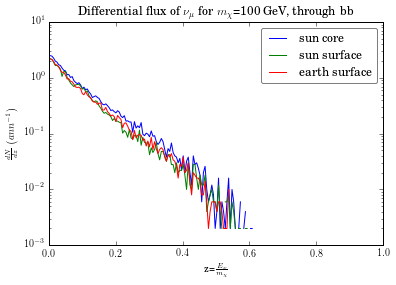

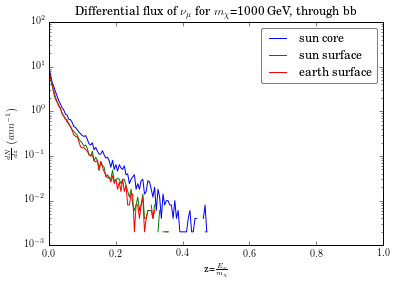

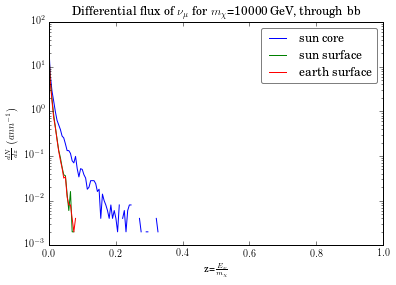

In [76]:
ms = [100,1000,10000]
for m in ms:
    surfaceComparisonPlot(m,'bb','nu_mu',save=True)